In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

In [2]:
# Build DataFrame
df = pd.read_csv("./Ethereum Historical Data.csv", thousands=",")
df = df.loc[:, ['Date', 'High', 'Low', 'Open', 'Vol', 'Price']]
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
df.set_index('Date', inplace=True)

In [3]:
# Parse Volume values from str to float
def parse_volume(value):
    if isinstance(value, str):
        if value == '-':
            return 0.0
        elif value.endswith('K'):
            return float(value.replace('K', '')) * 1e3
        elif value.endswith('M'):
            return float(value.replace('M', '')) * 1e6
        elif value.endswith('B'):
            return float(value.replace('B', '')) * 1e9
        else:
            return float(value)
    return value

df['Vol'] = df['Vol'].apply(parse_volume)

In [4]:
train_df = df.iloc[365:]
test_df = df.iloc[:365]

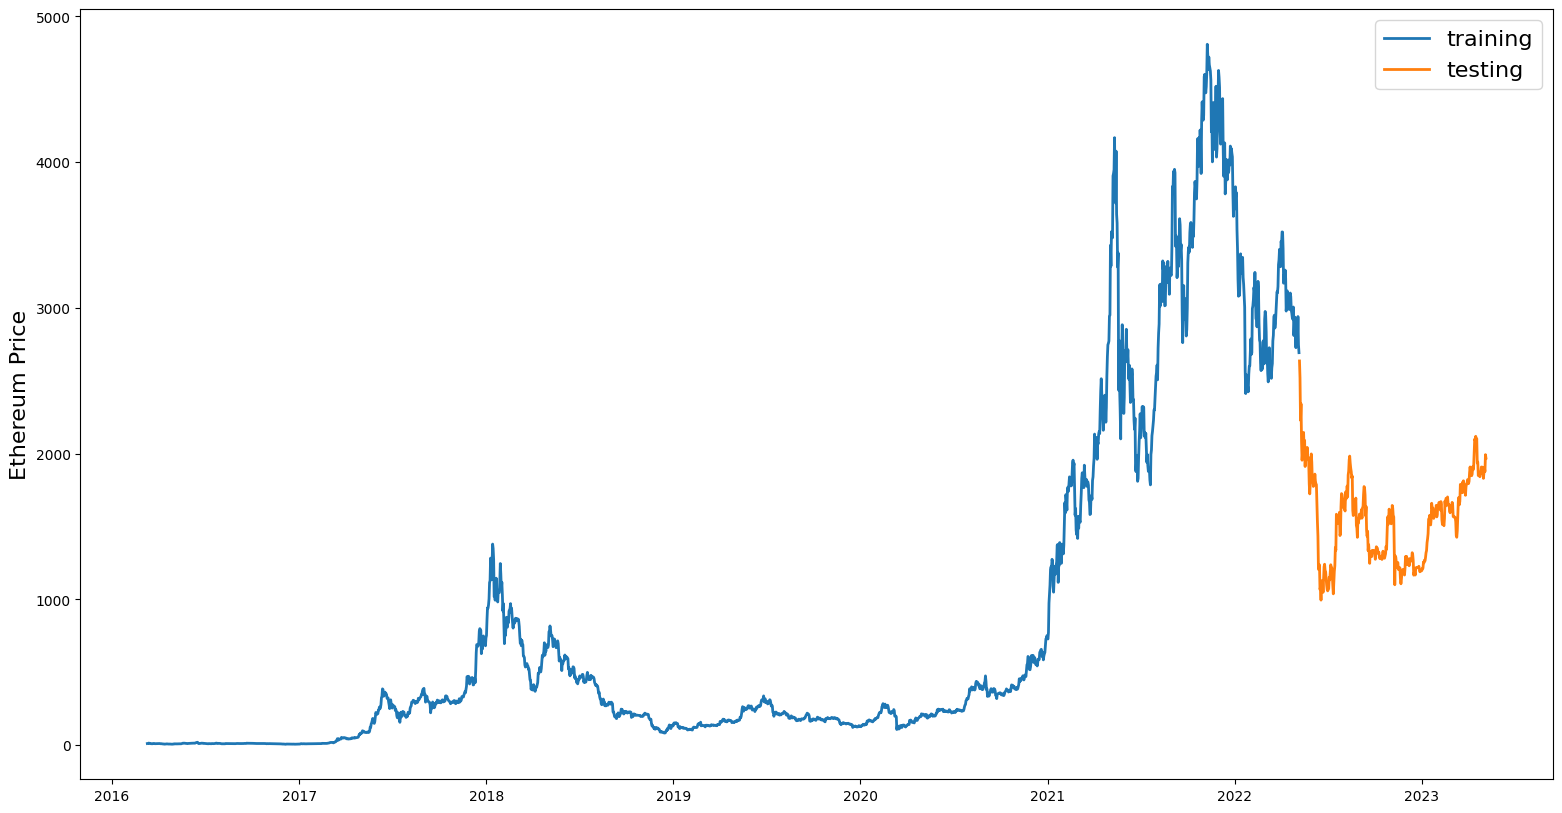

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(19, 10))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Ethereum Price', fontsize=16)
    ax.legend(loc='best', fontsize=16)

aim = "Price"
line_plot(train_df[aim], test_df[aim], 'training', 'testing', title='')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df[['High', 'Low', 'Open', 'Vol', 'Price']])
scaled_test_data = scaler.transform(test_df[['High', 'Low', 'Open', 'Vol', 'Price']])

In [7]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length, -1]  # Price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5

# Create sequences for both training and testing data
X_train, y_train = create_sequences(scaled_train_data, sequence_length)
X_test, y_test = create_sequences(scaled_test_data, sequence_length)

In [8]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
71/71 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 2/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 4/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 5/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 7/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 9/100
71/71 [==============================] - 0s 2ms/step - loss: 8.4509e-04
Epoch 10/100
71/71 [==============================] - 0s 2ms/step - loss: 8.2649e-04
Epoch 11/100
71/71 [==============================] - 0s 2ms/step - loss: 8.6285e-04
Epoch 12/100
71/71 [==============================] - 0s 2ms/step - loss: 7.9788e-04
Epoch 13/100
71/71 [=

In [10]:
targets = test_df[aim][sequence_length:]
preds = model.predict(X_test).squeeze()

r2 = r2_score(y_test, preds)
mae = mean_absolute_error(preds, y_test)
mse = mean_squared_error(y_test, preds)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared Score (R2):", r2)

12/12 [==============================] - 0s 872us/step
Mean Absolute Error (MAE): 0.00508785002146214
Mean Squared Error (MSE): 4.6796873648775276e-05
R-squared Score (R2): 0.9867381904368022


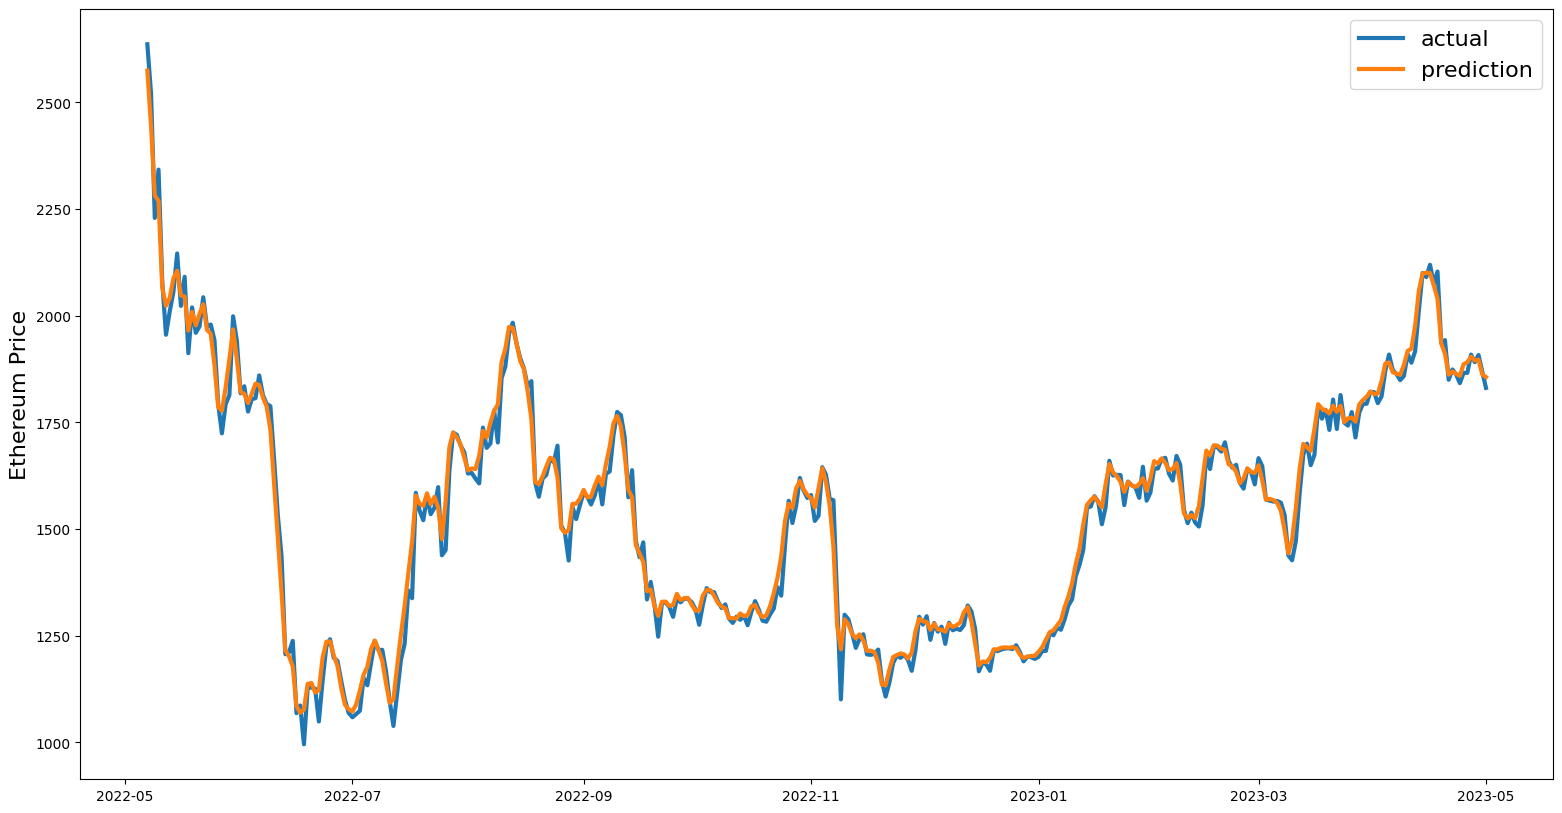

In [11]:
preds = pd.Series(data=preds, index=targets.index)
preds = preds.to_numpy()
preds_2d = preds.reshape(-1,1)
original_data = scaler.inverse_transform(np.hstack([preds_2d, np.zeros((preds_2d.shape[0], 4))]))
original_data = original_data[:, 0]
result_df = pd.DataFrame(data=original_data, index=targets.index, columns=['Price'])
result_df = result_df.iloc[::-1]

line_plot(targets, result_df, 'actual', 'prediction', lw=3)